In [1]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json

from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_context("notebook")
sns.set_style("dark")

In [4]:
use_example = False
min_event_amount = 0

if use_example:
    with open("example-real-data.json", "rb") as f:
        old_raw_data = json.load(f)
else:
    old_raw_data = {"data": []}
    files = os.listdir("./data/")
    for file in files:
        if file.endswith(".json"):
            with open(f"data/{file}", "rb") as f:
                match_data = json.load(f)
                match_ts = file.replace(".json", "")
                if len(match_data["data"]) < min_event_amount:
                    continue

                match_start_data = [e for e in match_data["data"] if e["Type"] == "MatchStart"][0]

                # Only account for PvE missions
                if "pve" not in match_start_data["mission"].lower():
                    continue

                print(file)
                old_raw_data["data"] += [{**el, "match_ts": match_ts} for el in match_data["data"]]

2024-02-26T13-43-30.622241.json
2024-02-26T13-53-07.244370.json
2024-02-26T13-56-28.790769.json
2024-02-26T14-32-46.303292.json
2024-02-26T14-38-34.247434.json
2024-02-26T14-47-36.296892.json
2024-02-26T15-06-31.913952.json
2024-02-26T15-08-51.577100.json
2024-02-26T15-13-36.703399.json
2024-02-26T16-18-22.619287.json
2024-02-26T17-34-36.863341.json
2024-02-26T17-50-08.830581.json
2024-02-26T18-17-18.864386.json
2024-02-26T19-01-45.602525.json
2024-02-26T19-19-41.169919.json
2024-02-26T21-07-02.287029.json
2024-02-26T22-57-13.598380.json
2024-02-27T00-08-36.477707.json
2024-02-27T00-59-40.760718.json
2024-02-27T01-16-27.941430.json
2024-02-27T05-52-02.006779.json
2024-02-27T05-53-43.512893.json
2024-02-27T06-18-33.043105.json
2024-02-27T06-30-47.620958.json
2024-02-27T06-49-59.112303.json
2024-02-27T10-03-24.647216.json
2024-02-27T10-20-56.163393.json
2024-02-27T10-32-46.090293.json
2024-02-27T10-36-01.895502.json
2024-02-27T10-38-03.187262.json
2024-02-27T10-40-50.449275.json
2024-02-

In [5]:
len(old_raw_data["data"])

53254

## Loading raw data from analytics system

In [6]:
is_veteran_regex = r'\w+\-\w*V\w*|Terminator.*'

In [7]:
pve_factions = ["Tyranids"]

In [8]:
show_outliers = False
share_x = 'all'

In [9]:
raw_data = []

for el in old_raw_data["data"]:
    # Value
    if "value" in el:
        el["value"] = float(el["value"])

    # Unique ts of match
    if "i" in el:
        el["i"] = el["i"] + "-" + el["match_ts"]
    if "t" in el:
        el["t"] = el["t"] + "-" + el["match_ts"]
    if "ips" in el:
        el["ips"] = el["ips"] + "-" + el["match_ts"]
    if "tps" in el:
        el["tps"] = el["tps"] + "-" + el["match_ts"]

    # Classes
    if "il" in el and "if" in el:
        el["i-faction-class"] = el["if"] + "-" + el["il"]
        el["i-is-veteran"] = bool(re.search(is_veteran_regex, el["i-faction-class"]))

    if "tl" in el and "tf" in el:
        el["t-faction-class"] = el["tf"] + "-" + el["tl"]
        el["t-is-veteran"] = bool(re.search(is_veteran_regex, el["t-faction-class"]))

    # Instigator coords
    if "ic" in el:
        el["ic_x"] = float(el["ic"].split(" ")[0].split("=")[1])
    if "ic" in el:
        el["ic_y"] = float(el["ic"].split(" ")[1].split("=")[1])

    # Target coords
    if "tc" in el:
        el["tc_x"] = float(el["tc"].split(" ")[0].split("=")[1])
    if "tc" in el:
        el["tc_y"] = float(el["tc"].split(" ")[1].split("=")[1])

    raw_data.append(el)

## Analyzing damage (per pawn, per class)

In [10]:
damage_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Damage"])

In [11]:
# Removing friendly fire when analyzing damage
damage_df = damage_df[damage_df["if"] != damage_df["tf"]]

# Leave only damage from characters to characters
damage_df = damage_df[damage_df['i'].str.startswith("CH_") | damage_df['i'].str.startswith("ECRCharacter_")]
damage_df = damage_df[damage_df['t'].str.startswith("CH_") | damage_df['i'].str.startswith("ECRCharacter_")]

In [12]:
damage_per_pawn = damage_df.groupby(["i"]).agg(
    damage_per_life=('value', 'sum'),
    loadout=('i-faction-class', 'first'),
    is_veteran=('i-is-veteran', 'first'),
    faction=('if', 'first')
)

In [13]:
median_damage_per_pawn = damage_per_pawn["damage_per_life"].median()

In [14]:
damage_per_life_for_classes = damage_per_pawn.sort_values(by='loadout').groupby("loadout").agg(
    mean_damage_per_life=('damage_per_life', 'mean'),
    std_damage_per_life=('damage_per_life', 'std')
)
damage_per_life_for_classes

,mean_damage_per_life,std_damage_per_life
loadout,,
CSM-GravCannonStandard,1133.333333,635.164021
CSM-HboS,3455.738424,4201.257305
CSM-JpaS,171.892939,188.770515
CSM-LcaS,1614.705623,1491.758171
CSM-MelS,960.726270,556.178162
CSM-PcaS,3717.141786,4948.614029
CSM-SupS,1120.174408,1101.794890
CSM-TacS,3330.843746,3431.089483
LSM-GravCannonStandard,1864.482863,1109.560423


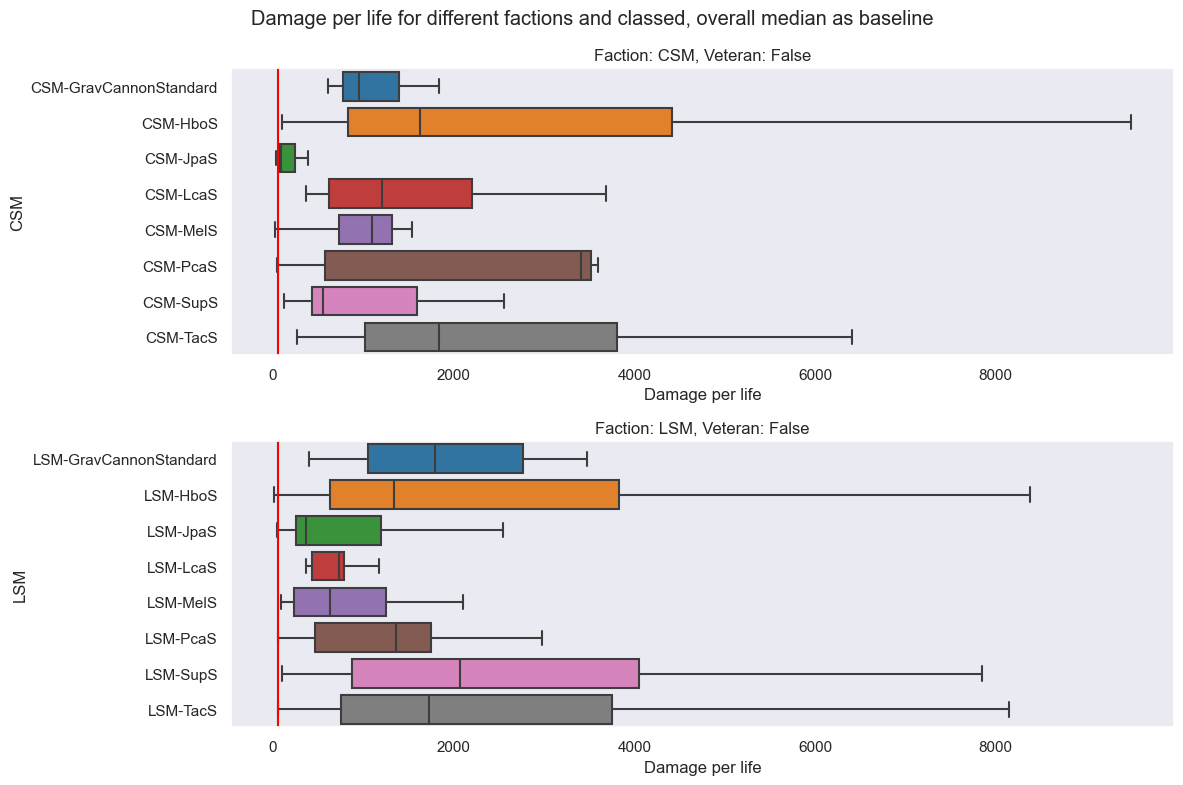

In [15]:
damage_per_pawn_players = damage_per_pawn[~damage_per_pawn["faction"].isin(pve_factions)]

# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(damage_per_pawn_players['faction'].unique()),
    ncols=len(damage_per_pawn_players['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(damage_per_pawn_players.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    sns.boxplot(x='damage_per_life', y='loadout', data=subset, ax=ax, orient='h', showfliers=show_outliers)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Damage per life')
    ax.set_ylabel(faction)

    ax.axvline(x=median_damage_per_pawn, color='red')

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

fig.suptitle("Damage per life for different factions and classed, overall median as baseline")

# Adjust layout
plt.tight_layout()
plt.show()

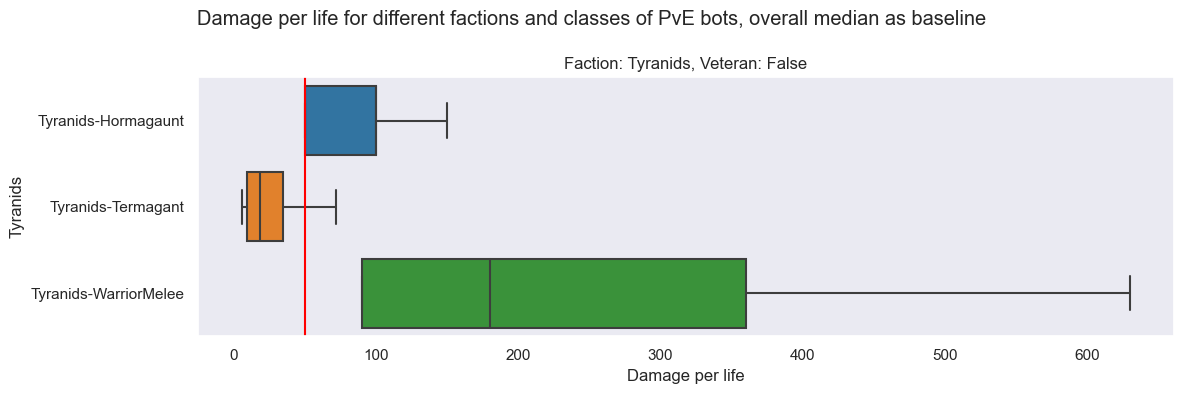

In [16]:
damage_per_pawn_bots = damage_per_pawn[damage_per_pawn["faction"].isin(pve_factions)]

# Create a single subplot if only one faction and veteran
if len(damage_per_pawn_bots['faction'].unique()) == 1 and len(damage_per_pawn_bots['is_veteran'].unique()) == 1:
    fig, ax = plt.subplots(figsize=(12, 4))
    subset = damage_per_pawn_bots.sort_values(by='loadout')  # Sort by 'loadout'
    sns.boxplot(x='damage_per_life', y='loadout', data=subset, ax=ax, orient='h', showfliers=show_outliers)

    # Set titles and axis labels
    ax.set_title(f'Faction: {damage_per_pawn_bots["faction"].iloc[0]}, Veteran: {damage_per_pawn_bots["is_veteran"].iloc[0]}')
    ax.set_xlabel('Damage per life')
    ax.set_ylabel(damage_per_pawn_bots["faction"].iloc[0])

    ax.axvline(x=median_damage_per_pawn, color='red')

    # Set x-axis ticks for the subplot
    ax.tick_params(axis='x', labelbottom=True)

else:
    # Create a grid of subplots
    fig, axes = plt.subplots(
        nrows=len(damage_per_pawn_bots['faction'].unique()),
        ncols=len(damage_per_pawn_bots['is_veteran'].unique()),
        figsize=(12, 8),
        sharex=share_x
    )

    # Grouping into subplots
    for ((faction, veteran), subset), ax in zip(damage_per_pawn_bots.groupby(['faction', 'is_veteran']), axes.flatten()):
        subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
        sns.boxplot(x='damage_per_life', y='loadout', data=subset, ax=ax, orient='h', showfliers=show_outliers)

        # Set titles and axis labels
        ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
        ax.set_xlabel('Damage per life')
        ax.set_ylabel(faction)

        ax.axvline(x=median_damage_per_pawn, color='red')

        # Set x-axis ticks for each subplot
        ax.tick_params(axis='x', labelbottom=True)

fig.suptitle("Damage per life for different factions and classes of PvE bots, overall median as baseline")

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing XP (per pawn, per class and action)

In [17]:
xp_df = pd.DataFrame([el for el in raw_data if el["Type"] == "XP"])

# Leave only XP to characters
xp_df = xp_df[xp_df['t'].str.startswith("CH_")  | damage_df['i'].str.startswith("ECRCharacter_")]

# Leave only damage from characters to characters
xp_df = xp_df[xp_df['t'].str.startswith("CH_") | xp_df['t'].str.startswith("ECRCharacter_")]

xp_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,t-faction-class,t-is-veteran,tc_x,tc_y
0,ECRCharacter_SpaceMarine_C_2147395795-2024-02-...,100.0,PS_2147398168-2024-02-26T14-38-34.247434,CSM,TacS,X=-400.480 Y=-7292.030 Z=450.700,Enemy down,XP,2024-02-26T14-38-34.247434,CSM-TacS,False,-400.48,-7292.03
1,ECRCharacter_SpaceMarine_C_2147395795-2024-02-...,100.0,PS_2147398168-2024-02-26T14-38-34.247434,CSM,TacS,X=-349.930 Y=-7311.970 Z=450.700,Enemy down,XP,2024-02-26T14-38-34.247434,CSM-TacS,False,-349.93,-7311.97
2,ECRCharacter_SpaceMarine_C_2147395795-2024-02-...,100.0,PS_2147398168-2024-02-26T14-38-34.247434,CSM,TacS,X=-387.580 Y=-7217.770 Z=450.700,Enemy down,XP,2024-02-26T14-38-34.247434,CSM-TacS,False,-387.58,-7217.77
3,ECRCharacter_SpaceMarine_C_2147395795-2024-02-...,100.0,PS_2147398168-2024-02-26T14-38-34.247434,CSM,TacS,X=-577.860 Y=-7149.950 Z=450.700,Enemy down,XP,2024-02-26T14-38-34.247434,CSM-TacS,False,-577.86,-7149.95
4,ECRCharacter_SpaceMarine_C_2147395795-2024-02-...,100.0,PS_2147398168-2024-02-26T14-38-34.247434,CSM,TacS,X=-769.940 Y=-7167.780 Z=450.700,Enemy down,XP,2024-02-26T14-38-34.247434,CSM-TacS,False,-769.94,-7167.78


In [18]:
xp_per_pawn_and_action = xp_df.groupby(["t", "action"]).agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first'),
    is_veteran=('t-is-veteran', 'first'),
    faction=('tf', 'first')
)

In [19]:
xp_per_pawn = xp_df.groupby("t").agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first'),
    is_veteran=('t-is-veteran', 'first'),
    faction=('tf', 'first')
)

In [20]:
xp_per_life_for_class_and_action = xp_per_pawn_and_action.groupby(["loadout", "action"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std'),
    is_veteran=('is_veteran', 'first'),
    faction=('faction', 'first')
)

In [21]:
xp_per_life_for_class = xp_per_pawn.groupby(["loadout"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std')
)
xp_per_life_for_class

,mean_xp_per_life,std_xp_per_life
loadout,,
CSM-GravCannonStandard,916.666667,600.694043
CSM-HboS,2355.000000,2874.511165
CSM-JpaS,200.000000,141.421356
CSM-LcaS,300.000000,173.205081
CSM-MelS,658.333333,549.924237
CSM-PcaS,1703.166667,2490.683153
CSM-SupS,1015.900000,1121.004158
CSM-TacS,2182.054054,2295.269083
LSM-GravCannonStandard,1234.125000,1040.724533


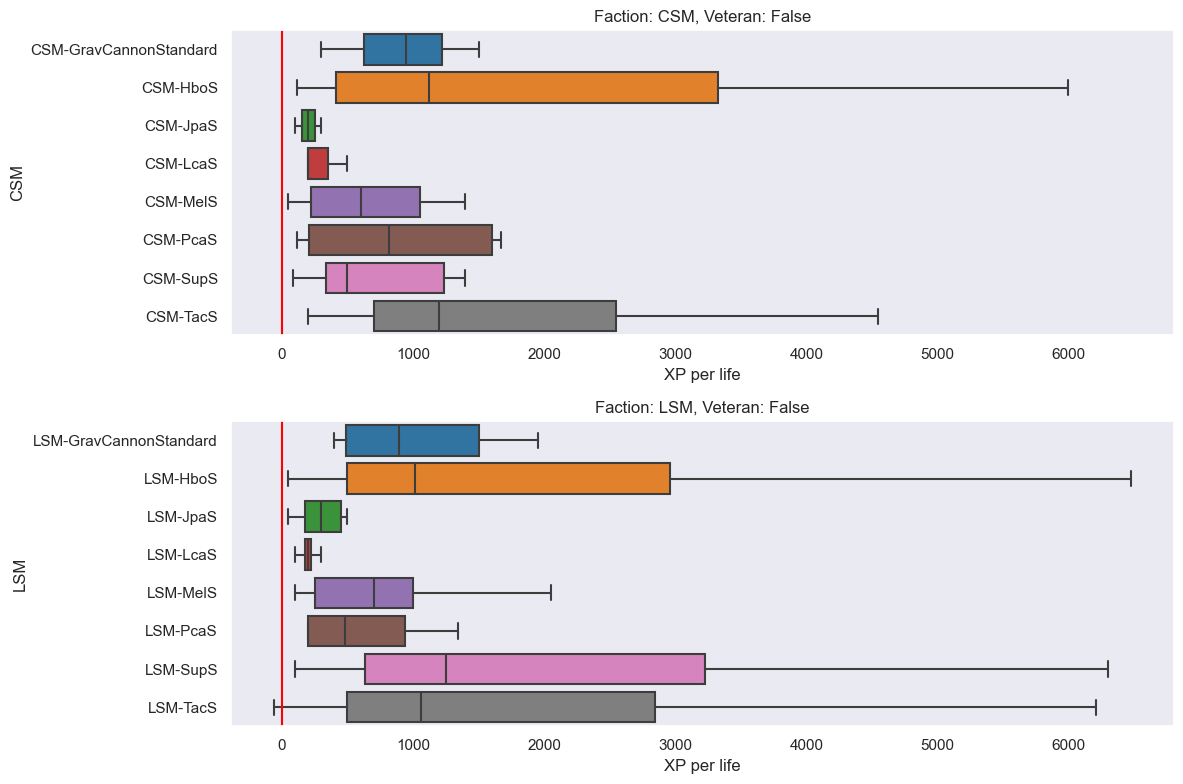

In [22]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(xp_per_pawn['faction'].unique()),
    ncols=len(xp_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(xp_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    sns.boxplot(x='xp_per_life', y='loadout', data=subset, ax=ax, orient='h', showfliers=show_outliers)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('XP per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

    ax.axvline(x=0, color='red')


# Adjust layout
plt.tight_layout()
plt.show()

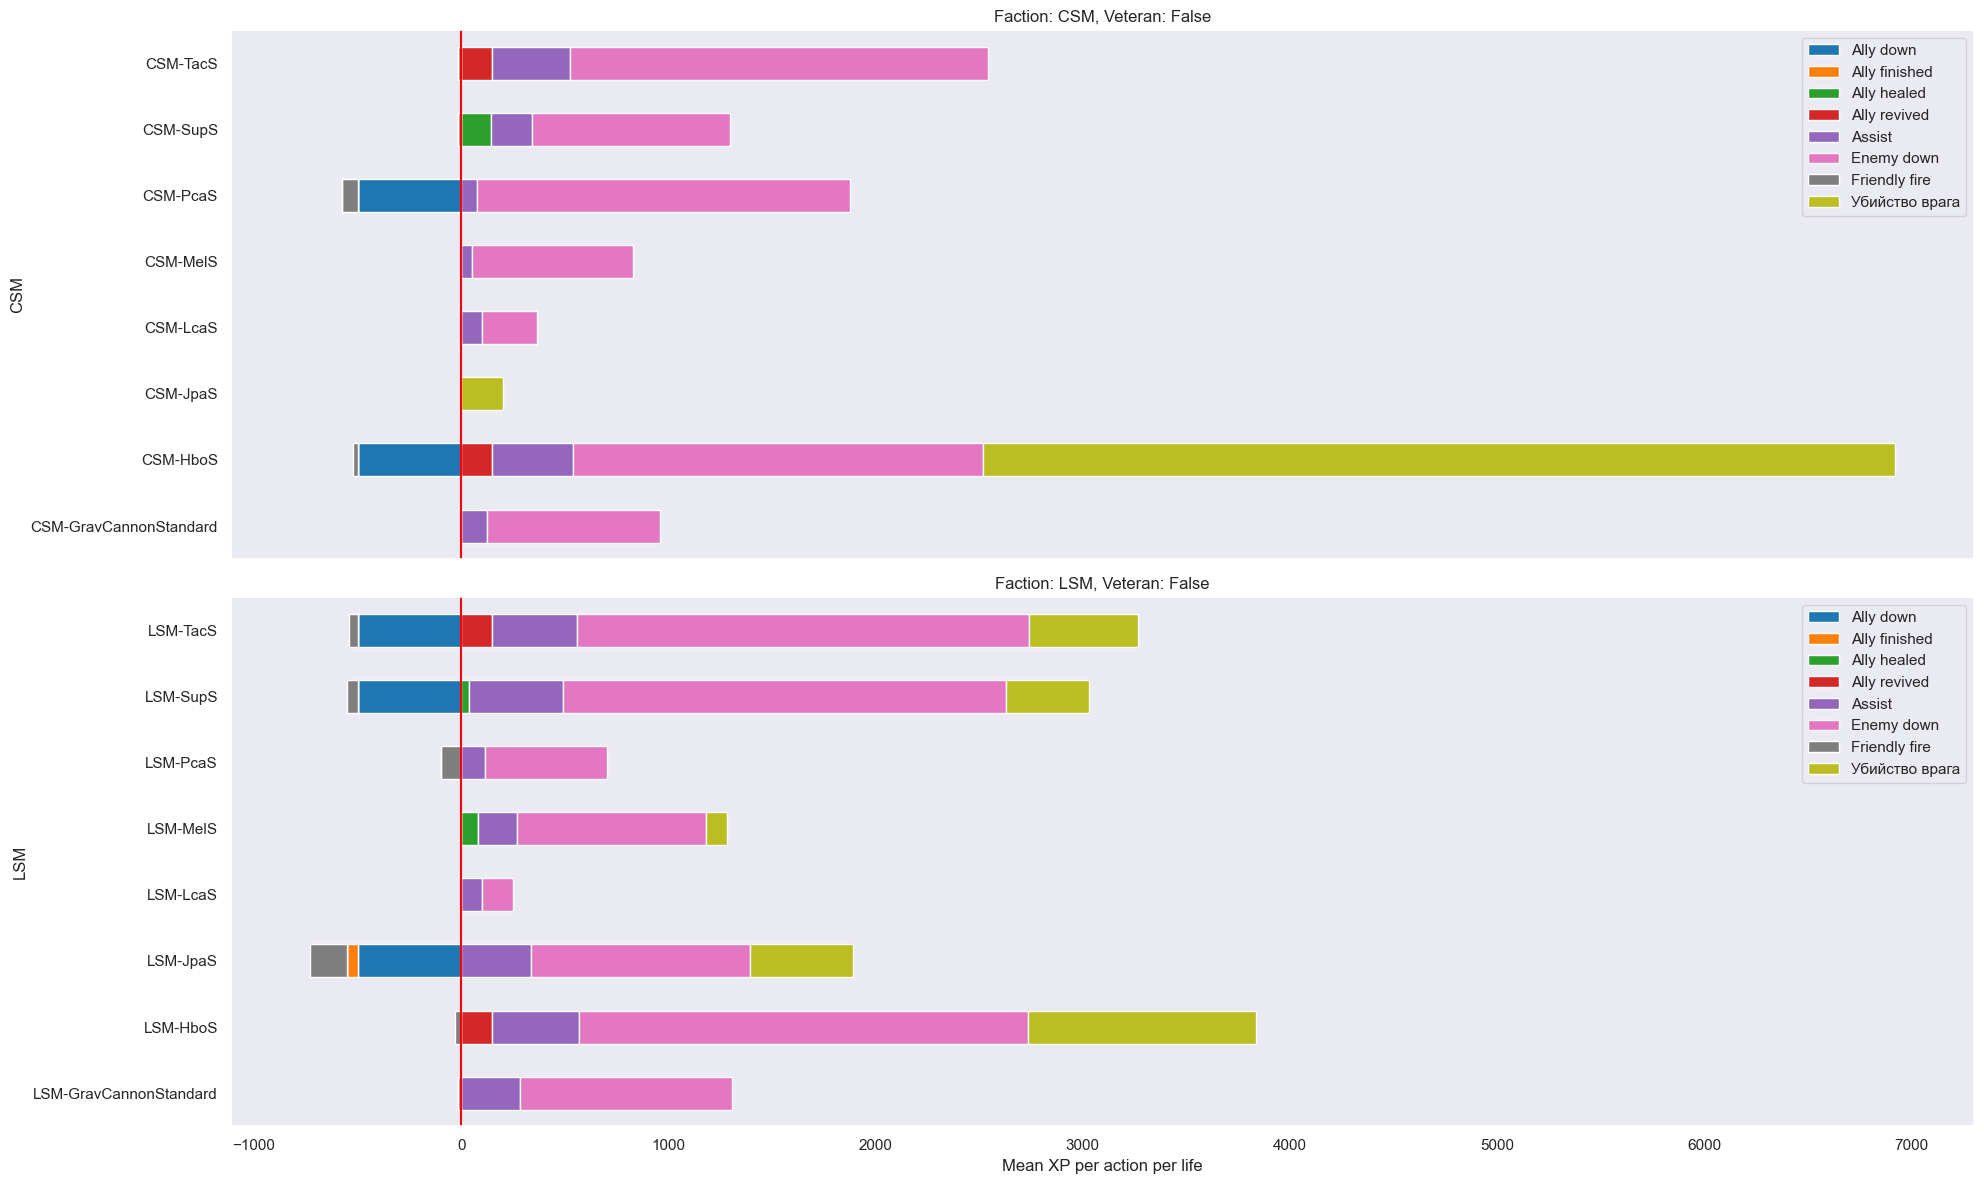

In [23]:
# Create a pivot table to reshape the data for plotting
pivot_xp_per_life_for_class_and_action = xp_per_life_for_class_and_action.reset_index()
pivot_xp_per_life_for_class_and_action = pivot_xp_per_life_for_class_and_action.pivot(index=['loadout', 'faction', 'is_veteran'], columns='action',
                                                                                      values='mean_xp_per_life')
pivot_xp_per_life_for_class_and_action = pivot_xp_per_life_for_class_and_action.reset_index().set_index("loadout")

# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(xp_per_pawn['faction'].unique()),
    ncols=len(xp_per_pawn['is_veteran'].unique()),
    figsize=(24, 16),
    sharex=share_x
)

# Define a custom color palette
custom_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Yellow-Green
    '#17becf',  # Cyan
    '#ffbb78',  # Light Orange
    '#98df8a',  # Light Green
    '#ffaec0',  # Light Pink
    '#c5b0d5',  # Light Purple
    '#1b9e77',  # Dark Green
]

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(pivot_xp_per_life_for_class_and_action.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    subset = subset.drop(["faction", "is_veteran"], axis=1)

    # Create a rotated stacked barplot with the custom color palette
    subset.plot(kind='barh', stacked=True, figsize=(20, 12), color=custom_colors, ax=ax)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Mean XP per action per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)
    ax.legend(bbox_to_anchor=(1, 1))

    ax.axvline(x=0, color='red')

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing KS ratios

In [24]:
kills_df = xp_df[xp_df["action"].isin(["Enemy down", "Убийство врага", "Elite down", "Убийство элиты"])]
kills_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,t-faction-class,t-is-veteran,tc_x,tc_y
0,ECRCharacter_SpaceMarine_C_2147395795-2024-02-...,100.0,PS_2147398168-2024-02-26T14-38-34.247434,CSM,TacS,X=-400.480 Y=-7292.030 Z=450.700,Enemy down,XP,2024-02-26T14-38-34.247434,CSM-TacS,False,-400.48,-7292.03
1,ECRCharacter_SpaceMarine_C_2147395795-2024-02-...,100.0,PS_2147398168-2024-02-26T14-38-34.247434,CSM,TacS,X=-349.930 Y=-7311.970 Z=450.700,Enemy down,XP,2024-02-26T14-38-34.247434,CSM-TacS,False,-349.93,-7311.97
2,ECRCharacter_SpaceMarine_C_2147395795-2024-02-...,100.0,PS_2147398168-2024-02-26T14-38-34.247434,CSM,TacS,X=-387.580 Y=-7217.770 Z=450.700,Enemy down,XP,2024-02-26T14-38-34.247434,CSM-TacS,False,-387.58,-7217.77
3,ECRCharacter_SpaceMarine_C_2147395795-2024-02-...,100.0,PS_2147398168-2024-02-26T14-38-34.247434,CSM,TacS,X=-577.860 Y=-7149.950 Z=450.700,Enemy down,XP,2024-02-26T14-38-34.247434,CSM-TacS,False,-577.86,-7149.95
4,ECRCharacter_SpaceMarine_C_2147395795-2024-02-...,100.0,PS_2147398168-2024-02-26T14-38-34.247434,CSM,TacS,X=-769.940 Y=-7167.780 Z=450.700,Enemy down,XP,2024-02-26T14-38-34.247434,CSM-TacS,False,-769.94,-7167.78


In [25]:
kills_per_pawn = kills_df.groupby(["t"]).agg(
    kill_count=('t', 'count'),
    loadout=('t-faction-class', 'first'),
    faction=('tf', 'first'),
    is_veteran=('t-is-veteran', 'first')
)
kills_per_pawn.head()

,kill_count,loadout,faction,is_veteran
t,,,,
ECRCharacter_SpaceMarine_C_2145170275-2024-02-27T14-09-35.083811,4,LSM-SupS,LSM,False
ECRCharacter_SpaceMarine_C_2145444008-2024-02-27T14-09-35.083811,116,LSM-HboS,LSM,False
ECRCharacter_SpaceMarine_C_2145484093-2024-02-27T13-58-16.951370,2,LSM-PcaS,LSM,False
ECRCharacter_SpaceMarine_C_2145485684-2024-02-27T13-58-16.951370,10,LSM-HboS,LSM,False
ECRCharacter_SpaceMarine_C_2145630389-2024-02-27T13-58-16.951370,29,LSM-SupS,LSM,False


In [26]:
kills_per_life_for_classes = kills_per_pawn.groupby("loadout").agg(
    mean_kills_per_life=('kill_count', 'mean'),
    std_kills_per_life=('kill_count', 'std')
)
kills_per_life_for_classes

,mean_kills_per_life,std_kills_per_life
loadout,,
CSM-GravCannonStandard,8.333333,5.507571
CSM-HboS,21.523810,26.574551
CSM-JpaS,2.000000,1.414214
CSM-LcaS,2.666667,1.154701
CSM-MelS,7.800000,5.167204
CSM-PcaS,18.000000,24.568272
CSM-SupS,9.555556,9.248123
CSM-TacS,20.189189,20.865759
LSM-GravCannonStandard,10.250000,8.680849


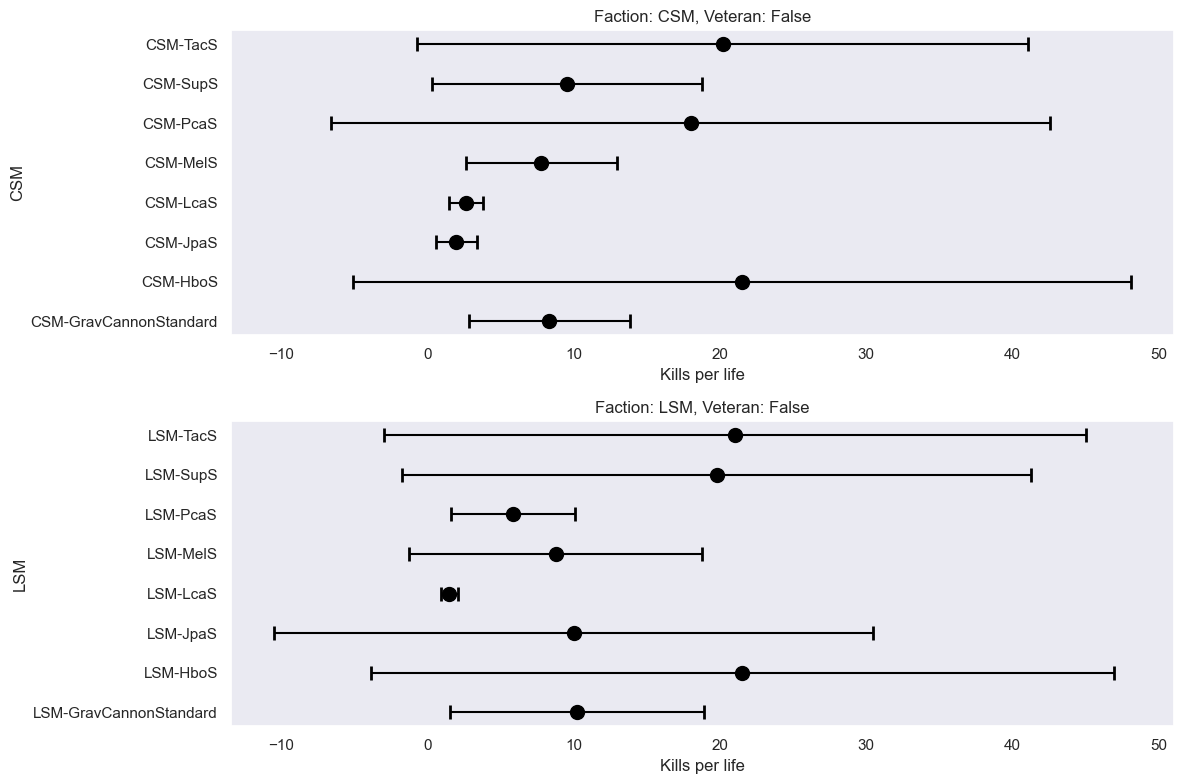

In [27]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(kills_per_pawn['faction'].unique()),
    ncols=len(kills_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(kills_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'

    grouped = subset.groupby('loadout')['kill_count']
    means = grouped.mean()
    stds = grouped.std()

    # Create a horizontal scatter plot for means
    ax.scatter(means, means.index, color='black', label='Mean', s=100, marker='o')  # Adjust the 's' parameter for size

    # Create vertical bars for standard deviation
    for i, (mean_val, std_val) in enumerate(zip(means, stds)):
        ax.errorbar(mean_val, i, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Kills per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing class frequencies

In [28]:
spawn_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Spawn"])

In [29]:
class_spawns = spawn_df["t-faction-class"].value_counts()

<Axes: title={'center': 'Classes spawn frequency'}, ylabel='t-faction-class'>

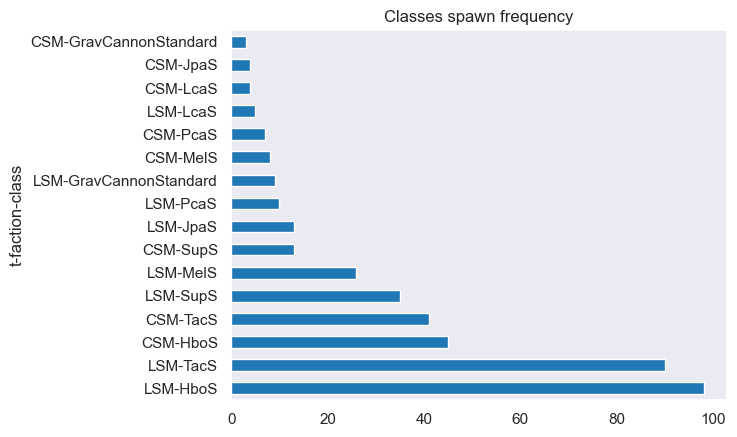

In [30]:
class_spawns.plot.barh(title="Classes spawn frequency")

# Maps and missions

In [31]:
faction_mapping = {
    "LSM": "LoyalSpaceMarines",
    "CSM": "ChaosSpaceMarines"
}

In [32]:
raw_match_end_data = []

def parse_team(team_string):
    try:
        team_data = json.loads(team_string)
    except:
        return None, None, None, None
    team_name = ",".join(sorted(team_data["alliance"]["factionNames"]))
    team_goal = team_data["goal"]
    team_score = team_data["score"]
    team_max_score = team_data["maxScore"]
    return team_name, team_goal, team_score, team_max_score

def parse_winner(winner_string):
    try:
        winner_data = json.loads(winner_string)
    except:
        return None, None
    team_name = ",".join(sorted(winner_data["alliance"]["factionNames"]))
    team_goal = winner_data["goal"]
    return team_name, team_goal

def get_positive_xp_per_team(match_ts, team_name):
    if team_name is None:
        return None

    xp = 0
    for event in raw_data:
        if event["match_ts"] == match_ts and event["Type"] == "XP" and faction_mapping.get(event.get("tf")) in team_name and event["value"] > 0:
            xp += event["value"]
    return xp

# def get_kill_spawns_ratio_per_team(match_ts, team_name):
#     if team_name is None:
#         return None
#
#     spawns = 0
#     kills = 0
#     for event in raw_data:
#         if event["match_ts"] == match_ts and event["Type"] == "Spawn" and faction_mapping.get(event.get("tf")) in team_name:
#             spawns += 1
#         if event["match_ts"] == match_ts and event["Type"] == "XP" and faction_mapping.get(event.get("tf")) in team_name and event["action"] == "Enemy down":
#             kills += 1
#     return kills / spawns if spawns != 0 else None

for el in tqdm(old_raw_data["data"]):
    if el["Type"] == "MatchEnd":
        match_ts = el["match_ts"]

        if "map" in el and "mission" in el:
            el["map-mission"] = el["map"] + "_" + el["mission"]

        if "t1" in el:
            el["t1_name"], el["t1_goal"], el["t1_score"], el["t1_max_score"] = parse_team(el["t1"])
            el.pop("t1")

            el["t1_xp"] = get_positive_xp_per_team(match_ts, el["t1_name"])
            # el["t1_ks_ratio"] = get_kill_spawns_ratio_per_team(match_ts, el["t1_name"])

        if "t2" in el:
            el["t2_name"], el["t2_goal"], el["t2_score"], el["t2_max_score"] = parse_team(el["t2"])
            el.pop("t2")

            el["t2_xp"] = get_positive_xp_per_team(match_ts, el["t2_name"])
            # el["t2_ks_ratio"] = get_kill_spawns_ratio_per_team(match_ts, el["t2_name"])

        if "t3" in el:
            el["t3_name"], el["t3_goal"], el["t3_score"], el["t3_max_score"] = parse_team(el["t3"])
            el.pop("t3")

            el["t3_xp"] = get_positive_xp_per_team(match_ts, el["t3_name"])
            # el["t3_ks_ratio"] = get_kill_spawns_ratio_per_team(match_ts, el["t3_name"])

        if "t4" in el:
            el["t4_name"], el["t4_goal"], el["t4_score"], el["t4_max_score"] = parse_team(el["t4"])
            el.pop("t4")

            el["t4_xp"] = get_positive_xp_per_team(match_ts, el["t4_name"])
            # el["t4_ks_ratio"] = get_kill_spawns_ratio_per_team(match_ts, el["t4_name"])

        if "winner" in el:
            el["winner_name"], el["winner_goal"] = parse_winner(el["winner"])
            el.pop("winner")

        raw_match_end_data.append(el)

100%|██████████| 53254/53254 [00:01<00:00, 38825.97it/s]


In [33]:
match_end_df = pd.DataFrame(raw_match_end_data)
print(match_end_df.shape)
match_end_df.head()

(158, 32)


,map,mission,pa,ts,duration,minduration,maxduration,Type,match_ts,map-mission,...,t3_score,t3_max_score,t3_xp,t4_name,t4_goal,t4_score,t4_max_score,t4_xp,winner_name,winner_goal
0,ForgeOfTheMoltenVein,B_GM_PVE_Horde_ForgeOfTheMoltenVein_C,,,900.0,900.0,900.0,MatchEnd,2024-02-26T13-43-30.622241,ForgeOfTheMoltenVein_B_GM_PVE_Horde_ForgeOfThe...,...,None,None,None,None,None,None,None,None,None,None
1,ForgeOfTheMoltenVein,B_GM_PVE_Horde_ForgeOfTheMoltenVein_C,,,900.0,900.0,900.0,MatchEnd,2024-02-26T13-53-07.244370,ForgeOfTheMoltenVein_B_GM_PVE_Horde_ForgeOfThe...,...,None,None,None,None,None,None,None,None,None,None
2,ForgeOfTheMoltenVein,B_GM_PVE_Horde_ForgeOfTheMoltenVein_C,,,900.0,900.0,900.0,MatchEnd,2024-02-26T13-56-28.790769,ForgeOfTheMoltenVein_B_GM_PVE_Horde_ForgeOfThe...,...,None,None,None,None,None,None,None,None,None,None
3,ForgeOfTheMoltenVein,B_GM_PVE_Horde_ForgeOfTheMoltenVein_C,,,900.0,900.0,900.0,MatchEnd,2024-02-26T14-32-46.303292,ForgeOfTheMoltenVein_B_GM_PVE_Horde_ForgeOfThe...,...,None,None,None,None,None,None,None,None,None,None
4,ForgeOfTheMoltenVein,B_GM_PVE_Horde_ForgeOfTheMoltenVein_C,,,900.0,900.0,900.0,MatchEnd,2024-02-26T14-38-34.247434,ForgeOfTheMoltenVein_B_GM_PVE_Horde_ForgeOfThe...,...,None,None,None,None,None,None,None,None,ChaosSpaceMarines,Attacker


## Preferred missions and maps

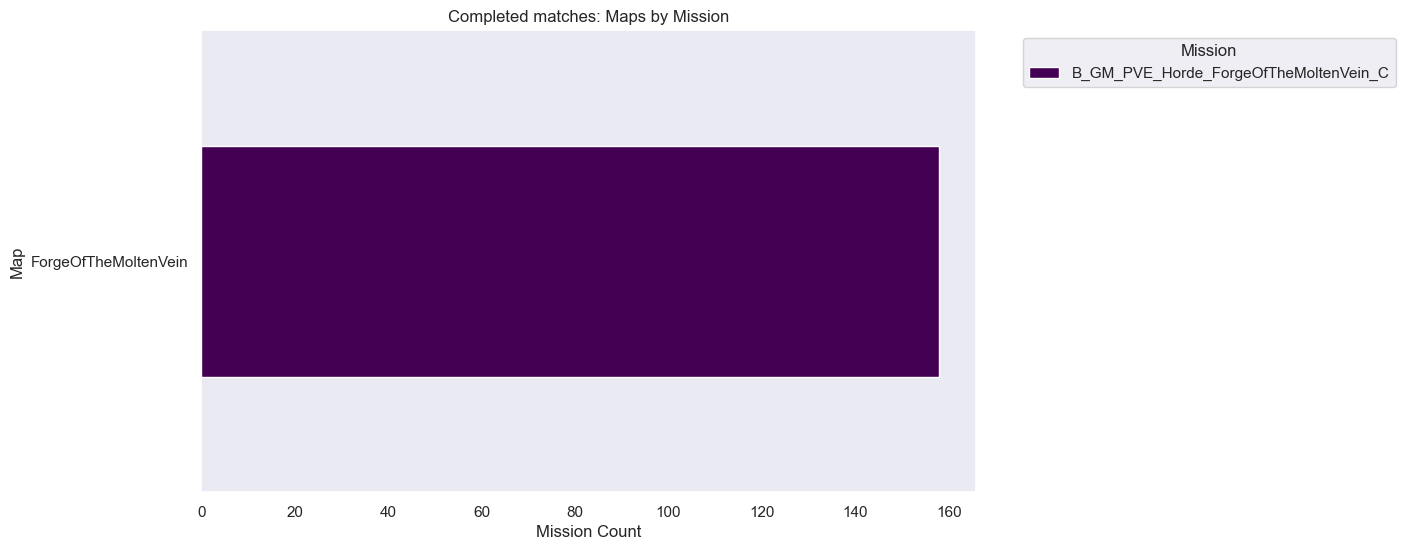

In [34]:
# Get the counts of each mission for each map
mission_counts = match_end_df.groupby(['map', 'mission']).size().unstack(fill_value=0)

# Create a horizontal bar plot
ax = mission_counts.plot(kind='barh', stacked=True, colormap='viridis', figsize=(10, 6))

# Customize the plot
ax.set_xlabel('Mission Count')
ax.set_ylabel('Map')
ax.set_title('Completed matches: Maps by Mission')

# Move the legend outside the plot
ax.legend(title='Mission', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

## Teams Win Rates

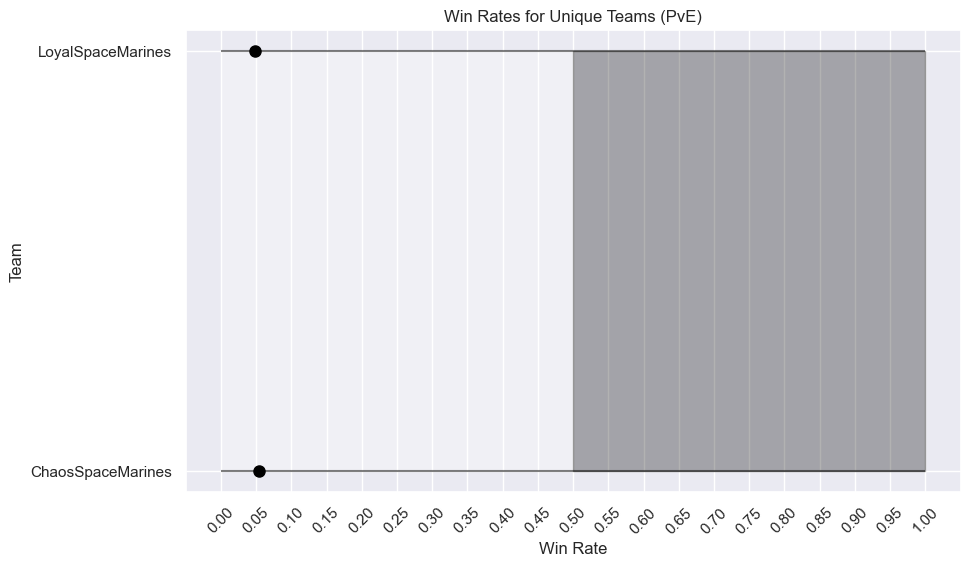

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame "match_end_df" with columns "winner_name", "t1_name", "t2_name", "t3_name", and "t4_name"

# Get all the unique strings from the DataFrame
all_teams = [s for s in match_end_df[["t1_name", "t2_name", "t3_name", "t4_name"]].values.ravel() if s]
unique_teams = pd.unique(all_teams)

# Create a dictionary to store the win rates for each string
win_rates = {}

# Calculate win rates for each string
for team in unique_teams:
    total_matches = match_end_df[
        (match_end_df["t1_name"] == team) |
        (match_end_df["t2_name"] == team) |
        (match_end_df["t3_name"] == team) |
        (match_end_df["t4_name"] == team)
        ]["winner_name"].shape[0]

    wins = match_end_df[match_end_df["winner_name"] == team]["winner_name"].count()

    win_rate = wins / total_matches if total_matches > 0 else 0
    win_rates[team] = win_rate

# Convert the dictionary to a DataFrame
win_rates_df = pd.DataFrame(list(win_rates.items()), columns=["Team", "Win Rate"])

# Sort the DataFrame by win rate
win_rates_df = win_rates_df.sort_values(by="Win Rate", ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
# Plot horizontal lines for each 'map-mission'
plt.hlines(y=range(len(unique_teams)), xmin=0, xmax=1, color='k', alpha=0.5)

# Plot points representing the frequency of 'Defender' winners
plt.plot(win_rates_df["Win Rate"], win_rates_df["Team"], marker='o', color='black', linestyle='None', markersize=8)

# Fill the area left of 0.5 with red and right of 0.5 with blue
plt.fill_betweenx([0, len(unique_teams) - 1], 0, 0.5, color='white', alpha=0.3)
plt.fill_betweenx([0, len(unique_teams) - 1], 0.5, 1, color='black', alpha=0.3)

plt.xticks(np.arange(0, 1.05, 0.05), rotation=45)
plt.grid()

# Set labels for axes and title
plt.xlabel("Win Rate")
plt.ylabel("Team")
plt.title("Win Rates for Unique Teams (PvE)")

# Display the plot
plt.show()

In [49]:
waves_completed = pd.DataFrame([el for el in raw_data if el["Type"] == "Wave"])
waves_completed["wave"] = waves_completed["wave"].apply(int)
waves_completed["player_amount"] = waves_completed["player_amount"].apply(int)

In [50]:
waves_completed

,player_amount,wave,loadouts,result,Type,match_ts
0,3,1,"SupportStandard,LasCannonStandard,TacticalStan...",failed,Wave,2024-02-26T14-38-34.247434
1,3,1,"HeavyBolterStandard,TacticalStandard,TacticalS...",passed,Wave,2024-02-26T14-38-34.247434
2,3,2,"HeavyBolterStandard,TacticalStandard,TacticalS...",passed,Wave,2024-02-26T14-38-34.247434
3,3,3,"HeavyBolterStandard,TacticalStandard,TacticalS...",passed,Wave,2024-02-26T14-38-34.247434
4,3,4,"HeavyBolterStandard,TacticalStandard,TacticalS...",passed,Wave,2024-02-26T14-38-34.247434
...,...,...,...,...,...,...
429,1,2,HeavyBolterStandard,failed,Wave,2024-03-02T07-07-45.226348
430,1,2,MeleeStandard,failed,Wave,2024-03-02T07-07-45.226348
431,1,1,JumpPackStandard,failed,Wave,2024-03-02T07-48-38.343916
432,1,1,TacticalStandard,failed,Wave,2024-03-02T07-48-38.343916


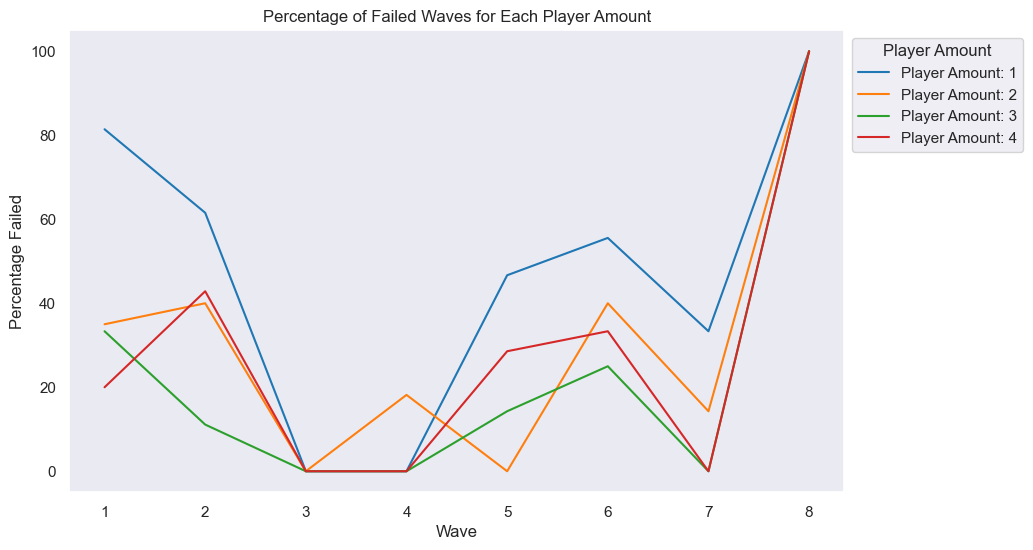

In [57]:
# Assuming your dataframe is named 'df'
# Sample data


df = waves_completed.copy()

# Convert 'passed' and 'failed' to 1 and 0
df['result'] = df['result'].map({'passed': 0, 'failed': 1})

# Calculate the percentage of passed waves for each wave and player_amount
result_pivot = df.pivot_table(index='wave', columns='player_amount', values='result', aggfunc='mean') * 100

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

for col in result_pivot.columns:
    ax.plot(result_pivot.index, result_pivot[col], label=f'Player Amount: {col}')

ax.set_title('Percentage of Failed Waves for Each Player Amount')
ax.set_xlabel('Wave')
ax.set_ylabel('Percentage Failed')
ax.legend(title='Player Amount', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()